# How to train Detectron2 with Custom COCO Datasets

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-up8pm7x2
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-up8pm7x2
     |████████████████████████████████| 276kB 14.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=48498 sha256=6109881158ab6967adc05abb145c958fde62934ad0837aa905cb00e58fb3918e
  Stored in directory: /tmp/pip-ephem-wheel-cache-933aj3bh/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=2eb7d396ef4bdd4fa8887db419c9c268566ad4c782c30bb74499499042856b6a
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfull

'1.7.0+cu101'

In [1]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.3
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [mask_v1 dataset]
which only has one class: Mask
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the Mask yet. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("mask_v1", {}, "/content/drive/MyDrive/Lab1/detectron2/labels.json", "/content/drive/MyDrive/Lab1/detectron2/data")

In [3]:
mask_v1_metadata = MetadataCatalog.get("mask_v1")
dataset_dicts = DatasetCatalog.get("mask_v1")

[12/06 16:40:32 d2.data.datasets.coco]: Loaded 19 images in COCO format from /content/drive/MyDrive/Lab1/detectron2/labels.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



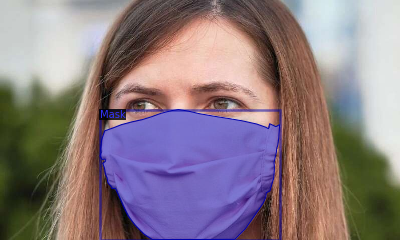

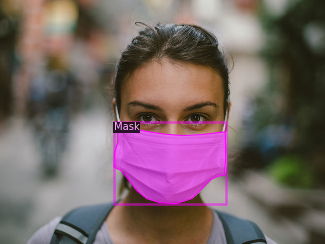

In [5]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mask_v1_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [17]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("mask_v1",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/06 16:59:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[12/06 16:59:45 d2.engine.train_loop]: Starting training from iteration 0
[12/06 16:59:55 d2.utils.events]:  eta: 0:08:14  iter: 19  total_loss: 1.572  loss_cls: 0.4705  loss_box_reg: 0.4569  loss_mask: 0.6233  loss_rpn_cls: 0.02598  loss_rpn_loc: 0.008415  time: 0.5019  data_time: 0.0226  lr: 0.00039962  max_mem: 3439M
[12/06 17:00:05 d2.utils.events]:  eta: 0:08:14  iter: 39  total_loss: 0.981  loss_cls: 0.1792  loss_box_reg: 0.543  loss_mask: 0.2038  loss_rpn_cls: 0.007706  loss_rpn_loc: 0.003204  time: 0.5166  data_time: 0.0047  lr: 0.00079922  max_mem: 3439M
[12/06 17:00:16 d2.utils.events]:  eta: 0:08:07  iter: 59  total_loss: 0.3147  loss_cls: 0.05256  loss_box_reg: 0.2211  loss_mask: 0.05822  loss_rpn_cls: 0.006029  loss_rpn_loc: 0.00404  time: 0.5178  data_time: 0.0047  lr: 0.0011988  max_mem: 3439M
[12/06 17:00:26 d2.utils.events]:  eta: 0:07:59  iter: 79  total_loss: 0.2174  loss_cls: 0.02586  loss_box_reg: 0.1359  loss_mask: 0.04625  loss_rpn_cls: 0.0001998  loss_rpn_loc: 0

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("mask_v1", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

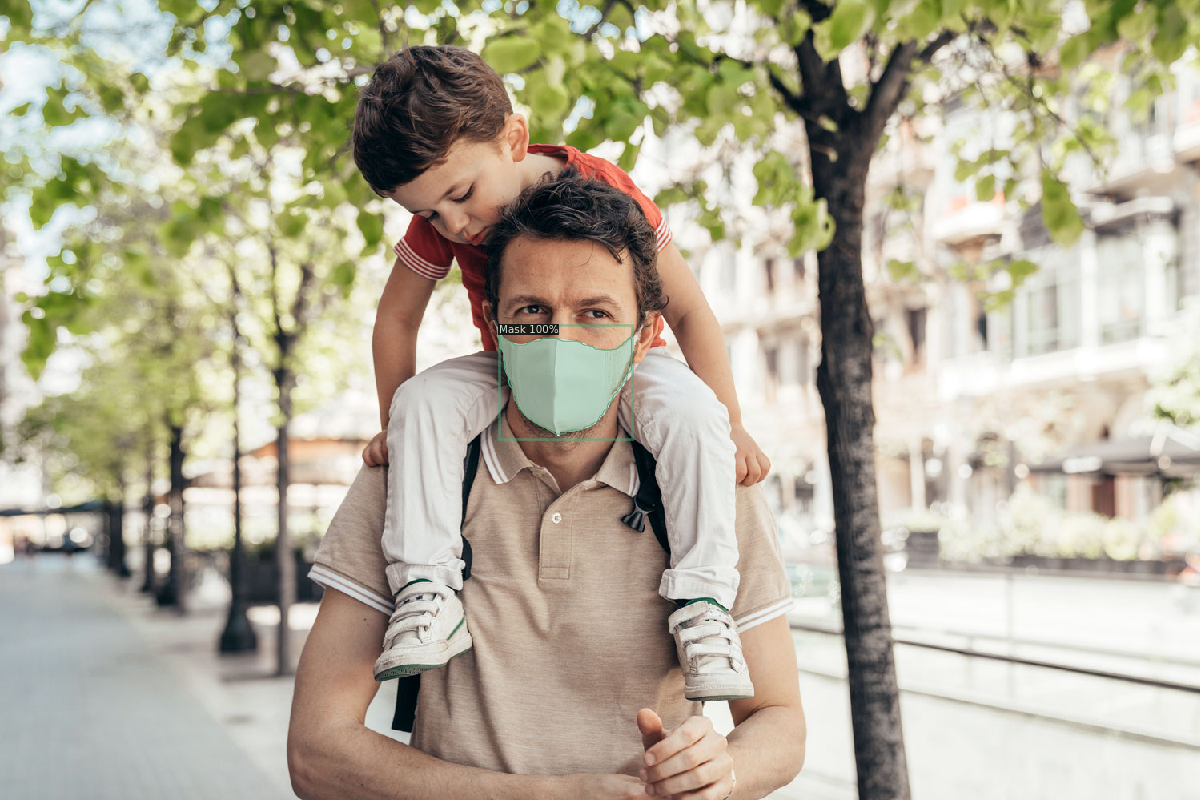

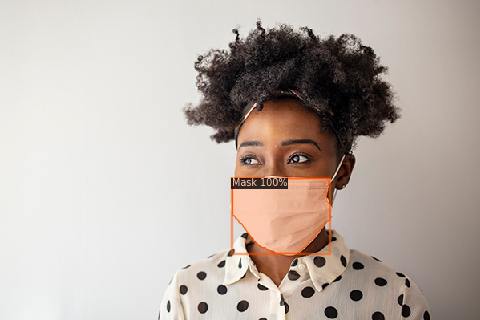

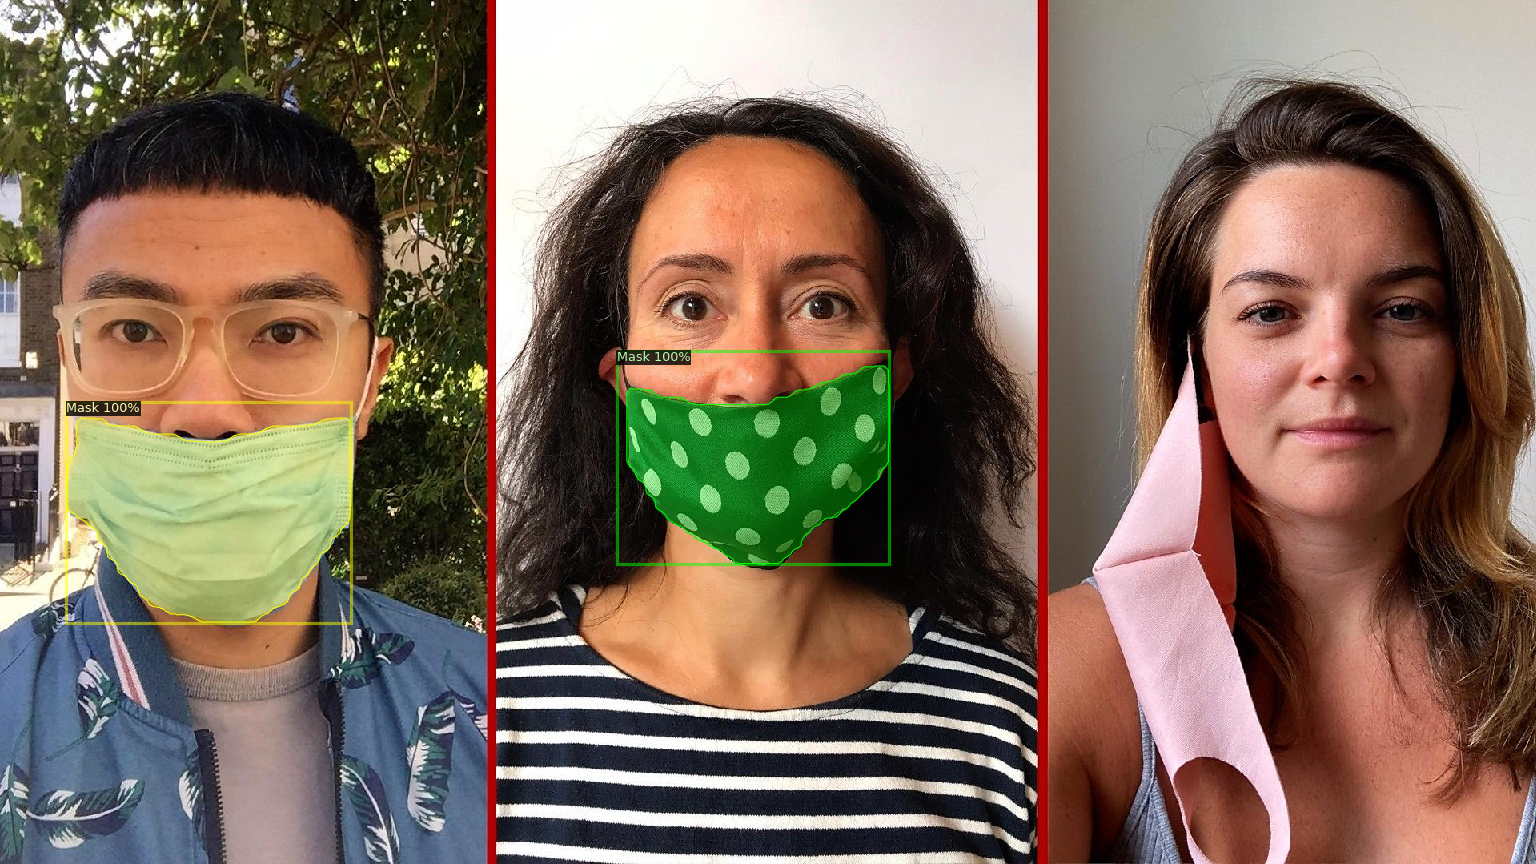

In [19]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=mask_v1_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [20]:
mask_v1_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/Lab1/detectron2/data', json_file='/content/drive/MyDrive/Lab1/detectron2/labels.json', name='mask_v1', thing_classes=['Mask'], thing_dataset_id_to_contiguous_id={1: 0})

## Benchmark inference speed

In [21]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.15,fps:6.73
